In [1]:
import os
import numpy as np
import cv2
from IPython.display import Image
from deskew_to_gray import preprocess_raw_image
from kmeans_to_binary import gray_to_binary
from segment_binary_image import text_to_characters
from filtering_and_scaling import image_to_numpy_array
from cnn_th import classify_digits, load_pretrain_model
from verify_result import download_reCaptcha, evaluate
from plot_util import plot_images

Using Theano backend.


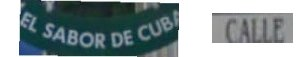

In [2]:
uid = np.random.randint(0, 15688)
# get a new ReCAPTCHA
path, context = download_reCaptcha(uid)
# show the CAPTCHA
Image(filename=path)

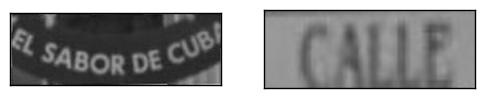

In [3]:
output_directory = os.getcwd() + "/output/"
# split the image to two halfs, deskew each one, 
# remove whitespaces and convert them to gray images
# the temporary results of each step are stored in output folder for reference
processed_grays = preprocess_raw_image(path, output_directory)
# show processed images
plot_images(processed_grays)

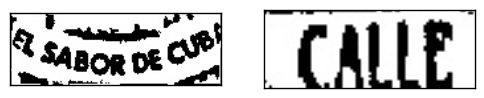

In [4]:
binary_images = []
kmeans_images = []
for gray in processed_grays:
    # kmeans with cluster = 2 to split the background and foreground
    # based on kmeans result to set hyper-parameters and
    # use adaptive thresholding to convert the gray image to binary image
    binary, kmeans = gray_to_binary(gray)
    binary_images.append(binary)
    kmeans_images.append(kmeans)
# show binary images
plot_images(binary_images)

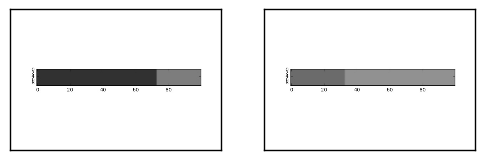

In [5]:
# show the result of kmeans clustering
plot_images(kmeans_images)

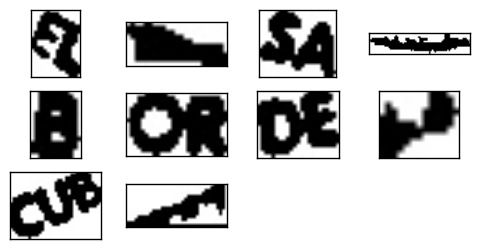

In [6]:
characters_list = []
for binary in binary_images:
    # segment the binary images, and output single characters
    characters_list.append(text_to_characters(binary, output_directory))
# show segmented characters for the first image
plot_images(characters_list[0])

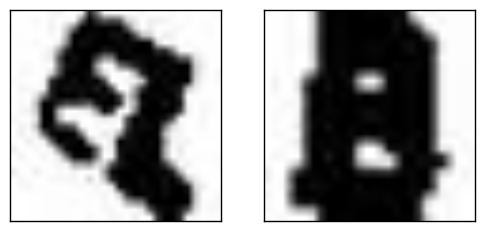

In [7]:
# filter and scale the image to 28 * 28
to_classify_list = []
filtered_chars_list = []
for characters in characters_list:
    filtered_chars, to_classify = image_to_numpy_array(characters)
    to_classify_list.append(to_classify)
    filtered_chars_list.append(filtered_chars)
# show the filtered and scaled images
plot_images(filtered_chars_list[0])

In [8]:
# load pretrained model to classify
pretrained_model = "pretrained_model.w"
model = load_pretrain_model(pretrained_model)
text = ""
num_chars = len(to_classify_list)
for i in xrange(0, num_chars):
    if len(filtered_chars_list[i]) <= 2:
        # better to ignore some very blurry images
        print "Failed to segment part", i, "of the image"
        continue
    text += classify_digits(model, to_classify_list[i]) + " "
text = text.strip()
print "The final result is [", text, "]"

Failed to segment part 0 of the image
The final result is [ CALLP ]


In [9]:
print "Passed verification successfully" if evaluate(text, context) else "Failed to pass verification"

Passed verification successfully
